In [2]:
import griddata as gd


net, time_steps, const_pv, const_load_household_P, const_load_household_Q, const_load_heatpump, const_load_heatpump_Q ,df_household_prognosis, df_season_heatpump_prognosis, heatpump_scaling_factors_df, T_amb, electricity_price = gd.setup_grid_IAS(season='summer')


In [3]:
net.bus

,name,vn_kv,type,zone,in_service,voltLvl,subnet,max_vm_pu,min_vm_pu,substation
0,MV1.101 Bus 52,20.0,b,NaN,True,5,MV1.101_LV4.101_Feeder6,1.055,0.965,NaN
1,LV4.101 Bus 1,0.4,b,NaN,True,7,LV4.101,1.100,0.900,NaN
2,LV4.101 Bus 35,0.4,b,NaN,True,7,LV4.101,1.100,0.900,NaN
3,LV4.101 Bus 14,0.4,b,NaN,True,7,LV4.101,1.100,0.900,NaN
4,LV4.101 Bus 22,0.4,b,NaN,True,7,LV4.101,1.100,0.900,NaN
5,LV4.101 Bus 4,0.4,b,NaN,True,7,LV4.101,1.100,0.900,NaN
6,LV4.101 Bus 16,0.4,b,NaN,True,7,LV4.101,1.100,0.900,NaN
7,LV4.101 Bus 25,0.4,b,NaN,True,7,LV4.101,1.100,0.900,NaN
8,LV4.101 Bus 26,0.4,b,NaN,True,7,LV4.101,1.100,0.900,NaN
9,LV4.101 Bus 9,0.4,b,NaN,True,7,LV4.101,1.100,0.900,NaN


In [3]:
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,phys_type,min_p_mw,min_q_mvar,profile,max_p_mw,slack_weight,voltLvl,max_q_mvar,subnet
0,PV_0,32,0.020,0.0,1.0,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PV_1,6,0.020,0.0,1.0,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PV_4,11,0.035,0.0,1.0,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PV_5,17,0.035,0.0,1.0,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PV_6,31,0.020,0.0,1.0,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PV_7,33,0.020,0.0,1.0,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,PV_8,28,0.020,0.0,1.0,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,PV_9,4,0.020,0.0,1.0,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,PV_10,8,0.020,0.0,1.0,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,PV_12,13,0.035,0.0,1.0,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
net.bus.vn_kv.iloc[15]

0.4

In [12]:
net2.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type,max_p_mw,voltLvl,min_p_mw,max_q_mvar,min_q_mvar,subnet,profile,controllable,q_mw
0,LV4.101 Load 1,32,0.004,0.001581,0.0,0.0,0.004301,1.0,True,NaN,NaN,7,NaN,NaN,NaN,LV4.101,H0-B,False,NaN
1,LV4.101 Load 30,6,0.003,0.001186,0.0,0.0,0.003226,1.0,True,NaN,NaN,7,NaN,NaN,NaN,LV4.101,H0-A,False,NaN
2,DEACTIVATE,19,0.000,0.000000,0.0,0.0,0.008602,1.0,True,NaN,NaN,7,NaN,NaN,NaN,LV4.101,G1-A,NaN,NaN
3,DEACTIVATE,14,0.000,0.000000,0.0,0.0,0.003226,1.0,True,NaN,NaN,7,NaN,NaN,NaN,LV4.101,H0-L,NaN,NaN
4,LV4.101 Load 18,11,0.006,0.002371,0.0,0.0,0.006452,1.0,True,NaN,NaN,7,NaN,NaN,NaN,LV4.101,H0-G,False,NaN
5,LV4.101 Load 20,17,0.006,0.002371,0.0,0.0,0.006452,1.0,True,NaN,NaN,7,NaN,NaN,NaN,LV4.101,H0-A,False,NaN
6,LV4.101 Load 4,31,0.004,0.001581,0.0,0.0,0.004301,1.0,True,NaN,NaN,7,NaN,NaN,NaN,LV4.101,H0-A,False,NaN
7,LV4.101 Load 16,33,0.004,0.001581,0.0,0.0,0.004301,1.0,True,NaN,NaN,7,NaN,NaN,NaN,LV4.101,H0-L,False,NaN
8,LV4.101 Load 22,28,0.003,0.001186,0.0,0.0,0.003226,1.0,True,NaN,NaN,7,NaN,NaN,NaN,LV4.101,H0-A,False,NaN
9,LV4.101 Load 6,4,0.003,0.001186,0.0,0.0,0.003226,1.0,True,NaN,NaN,7,NaN,NaN,NaN,LV4.101,H0-B,False,NaN


In [ ]:
print("Household ConstControl indices:", const_load_household.element_index)
print("Heat Pump ConstControl indices:", const_load_heatpump.element_index)

In [ ]:
print(time_steps)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add all buses as nodes
for bus in net.bus.index:
    G.add_node(bus)

# Add edges based on line connections with edge index as an attribute
line_edges = {}
for idx, line in enumerate(net.line.itertuples()):
    from_bus = line.from_bus
    to_bus = line.to_bus
    edge = (from_bus, to_bus)
    G.add_edge(from_bus, to_bus)
    line_edges[edge] = f"Line {idx+1}"

# Add edges for transformer connections with edge index as an attribute
trafo_edges = {}
for idx, trafo in enumerate(net.trafo.itertuples()):
    hv_bus = trafo.hv_bus
    lv_bus = trafo.lv_bus
    edge = (hv_bus, lv_bus)
    G.add_edge(hv_bus, lv_bus)
    trafo_edges[edge] = f"Trafo {idx}"

# Combine all edge indices into one dictionary
edge_labels = {**line_edges, **trafo_edges}

# Find the root bus (e.g., the slack bus or transformer bus)
root_bus = net.ext_grid.bus.iloc[0]

# Debugging: Ensure the root bus exists in the graph
if root_bus not in G.nodes:
    print(f"Warning: Root bus {root_bus} is not in the graph.")
    print(f"Available nodes: {list(G.nodes)}")
else:
    print(f"Root bus {root_bus} found.")

# Generate a topological sort to ensure hierarchy
levels = {node: 0 for node in G.nodes}
visited = set()

def assign_levels(node, level):
    if node in visited:
        return
    visited.add(node)
    levels[node] = level
    for neighbor in G.neighbors(node):
        assign_levels(neighbor, level + 1)

# Assign levels starting from the root bus
assign_levels(root_bus, 0)

# Define a position based on levels with increased vertical spacing
pos = {}
nodes_by_level = {}
vertical_spacing = 15  # Increase vertical spacing to 15 units

for node, level in levels.items():
    if level not in nodes_by_level:
        nodes_by_level[level] = []
    nodes_by_level[level].append(node)

for level, nodes in nodes_by_level.items():
    y = -level * vertical_spacing  # Adjusted vertical spacing
    x_positions = range(len(nodes))
    for x, node in zip(x_positions, nodes):
        pos[node] = (x, y)

# Plot the graph
plt.figure(figsize=(12, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    node_color="lightblue",
    font_size=10,
    arrowsize=10,
)

# Highlight the root bus
nx.draw_networkx_nodes(G, pos, nodelist=[root_bus], node_color="red", node_size=700)

# Add edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)

plt.title("Hierarchical Representation of the Grid with Transformer Connections and Edge Indices")
plt.show()


In [ ]:
import pandas as pd

# Load the CSV file (replace 'your_file.csv' with the actual file path)
file_path = 'householdPrognosis.csv'
df = pd.read_csv(file_path, sep=';')

# Display the first few rows of the dataframe
print("First few rows of the data:")
print(df.head())

# Display the header (column names) of the dataframe
print("\nColumn names (Header):")
print(df.columns)

# Print the length of the 'dayOfWeek' column
print("\nLength of the 'dayOfWeek' column:")
print(df['meanP'].count())  # .count() counts non-null entries in the column

# Print the last two values in the 'dayOfWeek' column
print("\nLast two values in the 'dayOfWeek' column:")
print(df['meanP'].tail(2))

In [ ]:
import matplotlib.pyplot as plt
# Filter the data for rows where season is 'winter'
winter_data = df[df['season'] == 'winter']

# Convert the 'meanP' column to numeric, replacing commas with dots
winter_data['meanP'] = winter_data['meanP'].str.replace(',', '.').astype(float)

# Plot the 'meanP' column
plt.figure(figsize=(10, 6))
plt.plot(winter_data['meanP'], marker='o', linestyle='-', color='b')
plt.title('MeanP during Winter Season')
plt.xlabel('Index')
plt.ylabel('MeanP')
plt.grid(True)
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add all buses as nodes
for bus in net.bus.index:
    G.add_node(bus)

# Add edges based on line connections with edge index as an attribute
line_edges = {}
for idx, line in enumerate(net.line.itertuples()):
    from_bus = line.from_bus
    to_bus = line.to_bus
    edge = (from_bus, to_bus)
    G.add_edge(from_bus, to_bus)
    line_edges[edge] = f"Line {idx}"

# Add edges for transformer connections with edge index as an attribute
trafo_edges = {}
for idx, trafo in enumerate(net.trafo.itertuples()):
    hv_bus = trafo.hv_bus
    lv_bus = trafo.lv_bus
    edge = (hv_bus, lv_bus)
    G.add_edge(hv_bus, lv_bus)
    trafo_edges[edge] = f"Trafo {idx}"

# Combine all edge indices into one dictionary
edge_labels = {**line_edges, **trafo_edges}

# Find the root bus (e.g., the slack bus or transformer bus)
root_bus = net.ext_grid.bus.iloc[0]

# Debugging: Ensure the root bus exists in the graph
if root_bus not in G.nodes:
    print(f"Warning: Root bus {root_bus} is not in the graph.")
    print(f"Available nodes: {list(G.nodes)}")
else:
    print(f"Root bus {root_bus} found.")

# Generate a topological sort to ensure hierarchy
levels = {node: 0 for node in G.nodes}
visited = set()

def assign_levels(node, level):
    if node in visited:
        return
    visited.add(node)
    levels[node] = level
    for neighbor in G.neighbors(node):
        assign_levels(neighbor, level + 1)

# Assign levels starting from the root bus
assign_levels(root_bus, 0)

# Define a position based on levels
pos = {}
nodes_by_level = {}
for node, level in levels.items():
    if level not in nodes_by_level:
        nodes_by_level[level] = []
    nodes_by_level[level].append(node)

for level, nodes in nodes_by_level.items():
    y = -level  # Downward hierarchy
    x_positions = range(len(nodes))
    for x, node in zip(x_positions, nodes):
        pos[node] = (x, y)

# Plot the graph
plt.figure(figsize=(12, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    node_color="lightblue",
    font_size=10,
    arrowsize=10,
)

# Highlight the root bus
nx.draw_networkx_nodes(G, pos, nodelist=[root_bus], node_color="red", node_size=700)

# Add edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)

plt.title("Hierarchical Representation of the Grid with Transformer Connections and Edge Indices")
plt.show()


In [ ]:
import pandapower as pp
# Buses and lines to remove
buses_to_drop = [14, 34, 9, 19]

# Remove lines associated with the buses to drop
lines_to_drop = net.line[
    (net.line.from_bus.isin(buses_to_drop)) | (net.line.to_bus.isin(buses_to_drop))
].index

# Drop the identified lines
pp.drop_lines(net, lines_to_drop)

# Drop the identified buses
pp.drop_buses(net, buses_to_drop)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add all buses as nodes
for bus in net.bus.index:
    G.add_node(bus)

# Add edges based on line connections
for line in net.line.itertuples():
    from_bus = line.from_bus
    to_bus = line.to_bus
    G.add_edge(from_bus, to_bus)

# Add edges for transformer connections
for trafo in net.trafo.itertuples():
    hv_bus = trafo.hv_bus
    lv_bus = trafo.lv_bus
    G.add_edge(hv_bus, lv_bus)

# Find the root bus (e.g., the slack bus or transformer bus)
root_bus = net.ext_grid.bus.iloc[0]

# Debugging: Ensure the root bus exists in the graph
if root_bus not in G.nodes:
    print(f"Warning: Root bus {root_bus} is not in the graph.")
    print(f"Available nodes: {list(G.nodes)}")
else:
    print(f"Root bus {root_bus} found.")

# Generate a topological sort to ensure hierarchy
levels = {node: 0 for node in G.nodes}
visited = set()

def assign_levels(node, level):
    if node in visited:
        return
    visited.add(node)
    levels[node] = level
    for neighbor in G.neighbors(node):
        assign_levels(neighbor, level + 1)

# Assign levels starting from the root bus
assign_levels(root_bus, 0)

# Define a position based on levels
pos = {}
nodes_by_level = {}
for node, level in levels.items():
    if level not in nodes_by_level:
        nodes_by_level[level] = []
    nodes_by_level[level].append(node)

for level, nodes in nodes_by_level.items():
    y = -level  # Downward hierarchy
    x_positions = range(len(nodes))
    for x, node in zip(x_positions, nodes):
        pos[node] = (x, y)

# Plot the graph
plt.figure(figsize=(12, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    node_color="lightblue",
    font_size=10,
    arrowsize=10,
)

# Highlight the root bus
nx.draw_networkx_nodes(G, pos, nodelist=[root_bus], node_color="red", node_size=700)
plt.title("Hierarchical Representation of the Grid with Transformer Connections")
plt.show()


In [ ]:
# Set constant loads to 3 kW for all loads except R11 to R18
constant_loads = net.load.index.difference([1, 2, 3, 4, 5])  # Indices of loads R1, I2, C1, C12, C13, C14, C17, C18, C19, C20
net.load.loc[constant_loads, 'p_mw'] = 15/1000

In [ ]:
# Initialize ConstControl controller to update values of the loads R11 to R18
profile_loads = net.load.index.intersection([0, 1, 2, 3, 4, 5])  # Indices of loads R11 to R18
const_load = control.ConstControl(net, element='load', element_index=profile_loads,
                                  variable='p_mw', data_source=ds, profile_name=["mult"]*len(profile_loads))


In [ ]:
# Run a power flow for the initial condition to check if the network is properly configured
try:
    pp.runpp(net)
except pp.optimal_powerflow.OPFNotConverged:
    print("Initial power flow did not converge. Please check the network configuration.")

In [ ]:
# initialising the outputwriter to save data to excel files in the current folder. You can change this to .json, .csv, or .pickle as well
ow = timeseries.OutputWriter(net, output_path="./", output_file_type=".xlsx")
# adding vm_pu of all buses and line_loading in percent of all lines as outputs to be stored
ow.log_variable('res_bus', 'vm_pu')
ow.log_variable('res_line', 'loading_percent')
ow.log_variable('res_load', 'p_mw')
ow.log_variable('res_load', 'q_mvar')


# starting the timeseries simulation for one day -> 96 15 min values.
timeseries.run_timeseries(net)
# now checkout the folders res_bus and res_line in your current working dir

In [ ]:
# Load the results
vm_pu = pd.read_excel('res_bus/vm_pu.xlsx', index_col=0)
loading_percent = pd.read_excel('res_line/loading_percent.xlsx', index_col=0)
load_p_mw = pd.read_excel('res_load/p_mw.xlsx', index_col=0)
load_q_mvar = pd.read_excel('res_load/q_mvar.xlsx', index_col=0)


In [ ]:
import pandapower.plotting as plot
# Plot the grid
plot.simple_plot(net, show_plot=True)

In [ ]:
import matplotlib.pyplot as plt
# Generate the plots
plt.figure(figsize=(10, 5))
plt.plot(vm_pu, label=vm_pu.columns)
plt.xlabel('Time Step')
plt.ylabel('Voltage Magnitude (p.u.)')
plt.title('Voltage Magnitude over Time')
plt.legend()
plt.show()


In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(loading_percent, label=loading_percent.columns)
plt.xlabel('Time Step')
plt.ylabel('Loading Percent')
plt.title('Line Loading over Time')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(load_p_mw, label=load_p_mw.columns)
plt.xlabel('Time Step')
plt.ylabel('Active Power Load (MW)')
plt.title('Active Power Load over Time')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(load_q_mvar, label=load_q_mvar.columns)
plt.xlabel('Time Step')
plt.ylabel('Reactive Power Load (MVAr)')
plt.title('Reactive Power Load over Time')
plt.legend()
plt.show()

In [3]:
import h5py

# Function to recursively explore groups and datasets
def explore_group(group, level=0):
    indent = "  " * level  # Indentation for better readability
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Group):
            print(f"{indent}Group: {key}")
            # Recursively explore the subgroup
            explore_group(item, level + 1)
        elif isinstance(item, h5py.Dataset):
            print(f"{indent}Dataset: {key}")
            print(f"{indent}  Shape: {item.shape}")
            print(f"{indent}  Data type: {item.dtype}")
            print(f"{indent}  First 5 lines of data:")
            print(item[:5])  # Adjust the slicing as needed
        else:
            print(f"{indent}Unknown item: {key}")

# Open the HDF5 file
file_path = "2020_weather.hdf5"  # Replace with the path to your HDF5 file
with h5py.File(file_path, "r") as hdf:
    print("Keys in the file:", list(hdf.keys()))
    
    # Access the 'WEATHER_SERVICE' group
    key = 'WEATHER_SERVICE'
    if key in hdf:
        group = hdf[key]
        print(f"Exploring '{key}' group recursively:")
        explore_group(group)
    else:
        print(f"Key '{key}' not found in the file.")

Keys in the file: ['WEATHER_SERVICE']
Exploring 'WEATHER_SERVICE' group recursively:
Group: IN
  Group: WEATHER_APPARENT_TEMPERATURE_TOTAL
    Dataset: table
      Shape: (102470,)
      Data type: [('index', '<i8'), ('APPARENT_TEMPERATURE:TOTAL', '<f8')]
      First 5 lines of data:
[(1577833200000000000, -0.5) (1577833500000000000, -0.5)
 (1577833800000000000, -1. ) (1577834100000000000, -1. )
 (1577834400000000000, -1. )]
  Group: WEATHER_ATMOSPHERIC_PRESSURE_TOTAL
    Dataset: table
      Shape: (102470,)
      Data type: [('index', '<i8'), ('ATMOSPHERIC_PRESSURE:TOTAL', '<f8')]
      First 5 lines of data:
[(1577833200000000000, 1035.5) (1577833500000000000, 1035.5)
 (1577833800000000000, 1035.5) (1577834100000000000, 1035.5)
 (1577834400000000000, 1035.5)]
  Group: WEATHER_PRECIPITATION_RATE_TOTAL
    Dataset: table
      Shape: (102470,)
      Data type: [('index', '<i8'), ('PRECIPITATION_RATE:TOTAL', '<f8')]
      First 5 lines of data:
[(1577833200000000000, 0.) (1577833500000

In [ ]:
import h5py
import pandas as pd

# Open the HDF5 file
file_path = "2020_weather.hdf5"  # Replace with the path to your HDF5 file
with h5py.File(file_path, "r") as hdf:
    # Access the dataset for apparent temperature
    dataset_path = "WEATHER_SERVICE/IN/WEATHER_APPARENT_TEMPERATURE_TOTAL/table"
    dataset = hdf[dataset_path]
    
    # Convert to pandas DataFrame
    data = pd.DataFrame(dataset[:])  # Convert structured array to DataFrame
    # Convert 'index' field (timestamp) to datetime
    data['index'] = pd.to_datetime(data['index'], unit='ns')
    
    # Filter for the first week of January 2020
    start_date = "2020-01-01"
    end_date = "2020-01-08"
    filtered_data = data[(data['index'] >= start_date) & (data['index'] < end_date)]
    
    # Export to CSV
    output_file = "temperatureWinter5m.csv"
    filtered_data.to_csv(output_file, index=False)
    print(f"Filtered data for the first week of January 2020 has been saved to '{output_file}'.")

In [22]:
import h5py
import pandas as pd

# Open the HDF5 file
file_path = "2020_weather.hdf5"  # Replace with the path to your HDF5 file
with h5py.File(file_path, "r") as hdf:
    # Access the dataset for apparent temperature
    dataset_path = "WEATHER_SERVICE/IN/WEATHER_APPARENT_TEMPERATURE_TOTAL/table"
    dataset = hdf[dataset_path]
    
    # Convert to pandas DataFrame
    data = pd.DataFrame(dataset[:])  # Convert structured array to DataFrame
    # Convert 'index' field (timestamp) to datetime
    data['index'] = pd.to_datetime(data['index'], unit='ns')
    
    # Filter for the week
    start_date = "2020-01-20"
    end_date = "2020-01-27"
    filtered_data = data[(data['index'] >= start_date) & (data['index'] < end_date)]
    
    # Set the 'index' column as the DataFrame index
    filtered_data.set_index('index', inplace=True)
    
    # Resample to 1h intervals and calculate the mean
    resampled_data = filtered_data.resample('1H').mean()
    
    # Export to CSV
    output_file = "temperatureWinter1h.csv"
    resampled_data.to_csv(output_file)
    print(f"1h resolution data for the first week of January 2020 has been saved to '{output_file}'.")

1h resolution data for the first week of January 2020 has been saved to 'temperatureWinter1h.csv'.


Index(['index', 'APPARENT_TEMPERATURE:TOTAL'], dtype='object')


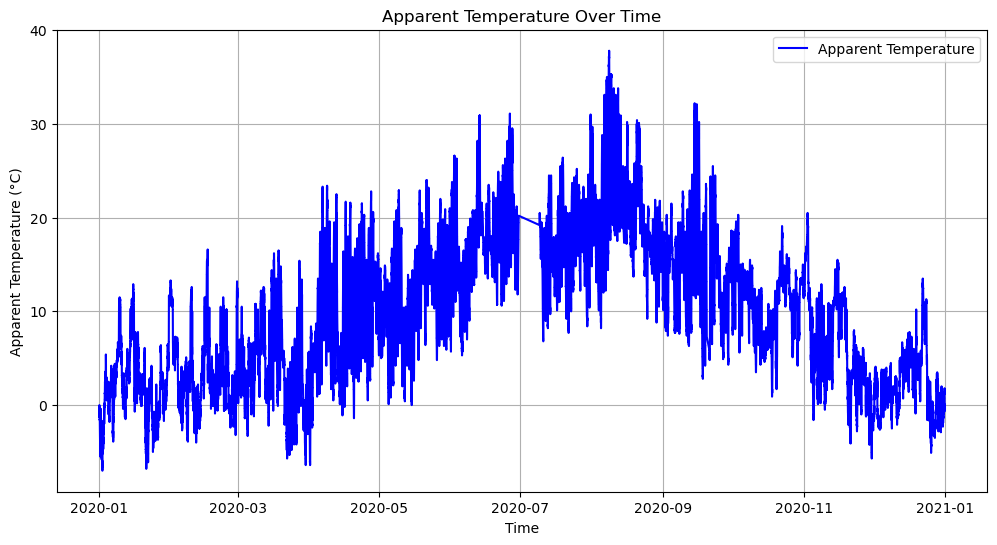

In [23]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt

# Open the HDF5 file
file_path = "2020_weather.hdf5"  # Replace with the path to your HDF5 file
with h5py.File(file_path, "r") as hdf:
    # Access the dataset for apparent temperature
    dataset_path = "WEATHER_SERVICE/IN/WEATHER_APPARENT_TEMPERATURE_TOTAL/table"
    dataset = hdf[dataset_path]
    
    # Convert to pandas DataFrame
    data = pd.DataFrame(dataset[:])  # Convert structured array to DataFrame

    # Convert 'index' field (timestamp) to datetime
    data['index'] = pd.to_datetime(data['index'], unit='ns')

print(data.columns)

# Correctly reference the actual column names
time_column = "index"  # Use the correct column name
temperature_column = "APPARENT_TEMPERATURE:TOTAL"  # Ensure this is the actual column name

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data[time_column], data[temperature_column], label="Apparent Temperature", color='b')

# Formatting the plot
plt.xlabel("Time")
plt.ylabel("Apparent Temperature (°C)")
plt.title("Apparent Temperature Over Time")
plt.legend()
plt.grid()

# Show the plot
plt.show()


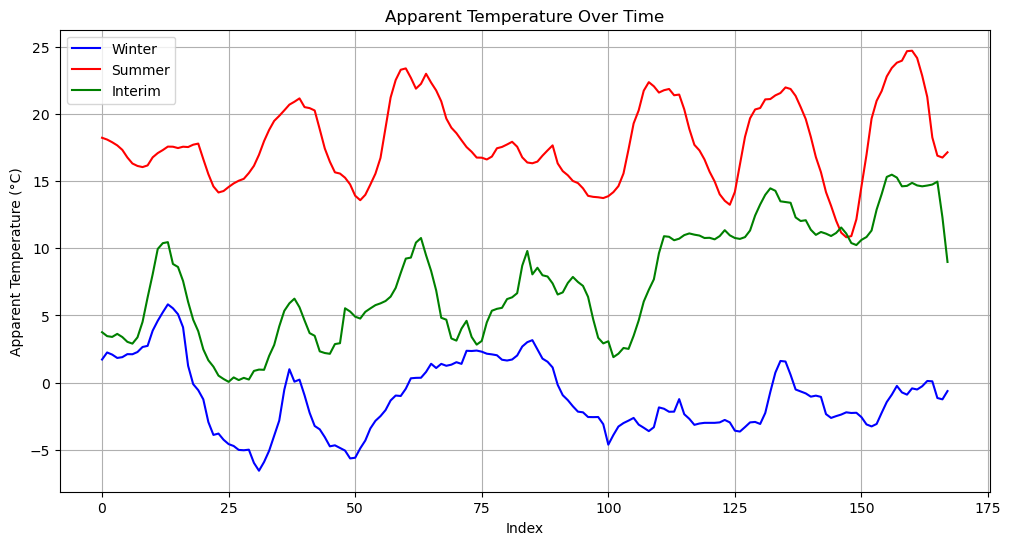

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# File names
files = {
    "Winter": "temperatureWinter1h.csv",
    "Summer": "temperatureSummer1h.csv",
    "Interim": "temperatureInterim1h.csv"
}

# Colors for each dataset
colors = {"Winter": "blue", "Summer": "red", "Interim": "green"}

# Dictionary to store DataFrames
dataframes = {}

# Load the data
for season, file in files.items():
    df = pd.read_csv(file, parse_dates=["index"])  # Read without setting index
    dataframes[season] = df

# Plot the data
plt.figure(figsize=(12, 6))

for season, df in dataframes.items():
    plt.plot(df.index, df["APPARENT_TEMPERATURE:TOTAL"], label=season, color=colors[season])

# Formatting the plot
plt.xlabel("Index")
plt.ylabel("Apparent Temperature (°C)")
plt.title("Apparent Temperature Over Time")
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [18]:
import h5py
import pandas as pd

# Open the HDF5 file
file_path = "2020_weather.hdf5"  # Replace with the path to your HDF5 file
with h5py.File(file_path, "r") as hdf:
    # Access the dataset for apparent temperature
    dataset_path = "WEATHER_SERVICE/IN/WEATHER_APPARENT_TEMPERATURE_TOTAL/table"
    dataset = hdf[dataset_path]
    
    # Convert to pandas DataFrame
    data = pd.DataFrame(dataset[:])  # Convert structured array to DataFrame
    # Convert 'index' field (timestamp) to datetime
    data['index'] = pd.to_datetime(data['index'], unit='ns')
    
    # Filter for the first week of January 2020
    start_date = "2020-01-06"
    end_date = "2020-01-13"
    filtered_data = data[(data['index'] >= start_date) & (data['index'] < end_date)]
    
    # Set the 'index' column as the DataFrame index
    filtered_data.set_index('index', inplace=True)
    
    # Resample to 1-hour intervals and calculate the mean
    resampled_data = filtered_data.resample('1H').mean()
    
    # Export to CSV
    output_file = "temperatureWinter1h.csv"
    resampled_data.to_csv(output_file)
    print(f"1-hour resolution data for the first week of January 2020 has been saved to '{output_file}'.")


1-hour resolution data for the first week of January 2020 has been saved to 'temperatureWinter1h.csv'.


In [ ]:
import pandas as pd

# Path to the CSV file
file_path = "pvPrognosis.csv"  # Replace with the correct path to your CSV file

# Load the CSV into a DataFrame
df = pd.read_csv(file_path)

# Print the first few lines
print("First few lines of the 15-min resolution data:")
print(df.head())
# Print the length of the DataFrame
print(f"The number of rows in the DataFrame: {len(df)}")

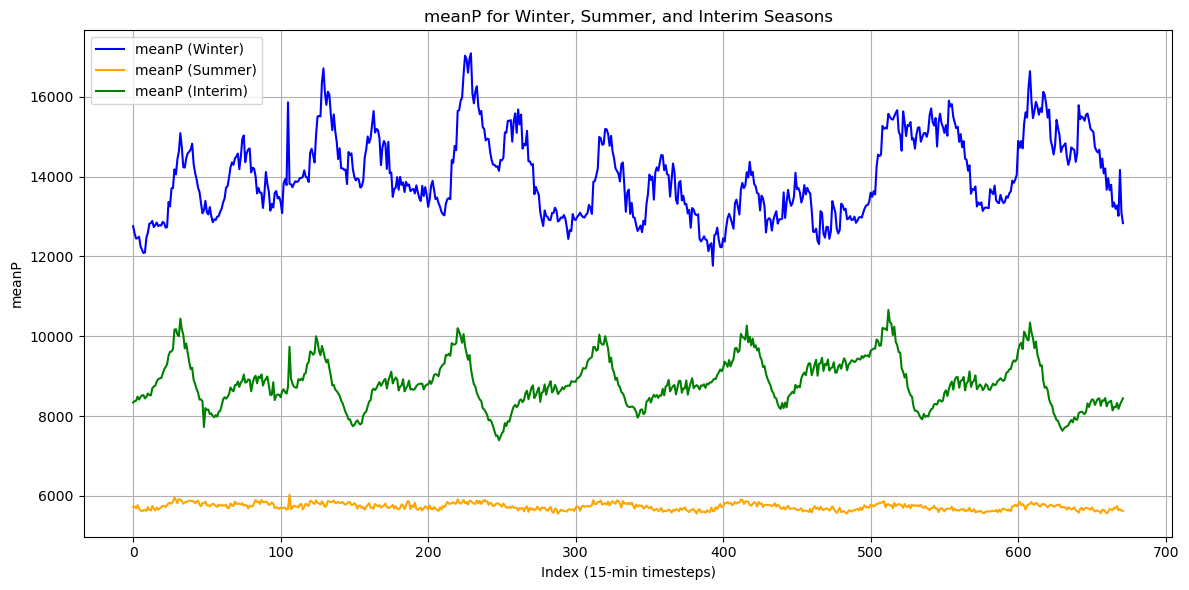

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file with proper settings for separator and decimal point
file_path = "heatpumpPrognosis.csv"
df = pd.read_csv(file_path, delimiter=';', decimal=',')

# Clean 'season' column
df['season'] = df['season'].str.strip()

# Filter data by season
df_winter = df[df['season'] == 'winter'].reset_index(drop=True)
df_summer = df[df['season'] == 'summer'].reset_index(drop=True)
df_interim = df[df['season'] == 'interim'].reset_index(drop=True)

# Plot all three seasons in the same figure
plt.figure(figsize=(12, 6))
plt.plot(df_winter.index, df_winter['meanP'], label='meanP (Winter)', color='blue')
plt.plot(df_summer.index, df_summer['meanP'], label='meanP (Summer)', color='orange')
plt.plot(df_interim.index, df_interim['meanP'], label='meanP (Interim)', color='green')

# Add labels, title, and legend
plt.xlabel('Index (15-min timesteps)')
plt.ylabel('meanP')
plt.title('meanP for Winter, Summer, and Interim Seasons')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


No handles with labels found to put in legend.


Max: 56446.12741124899, Mean: 12654.973830642617


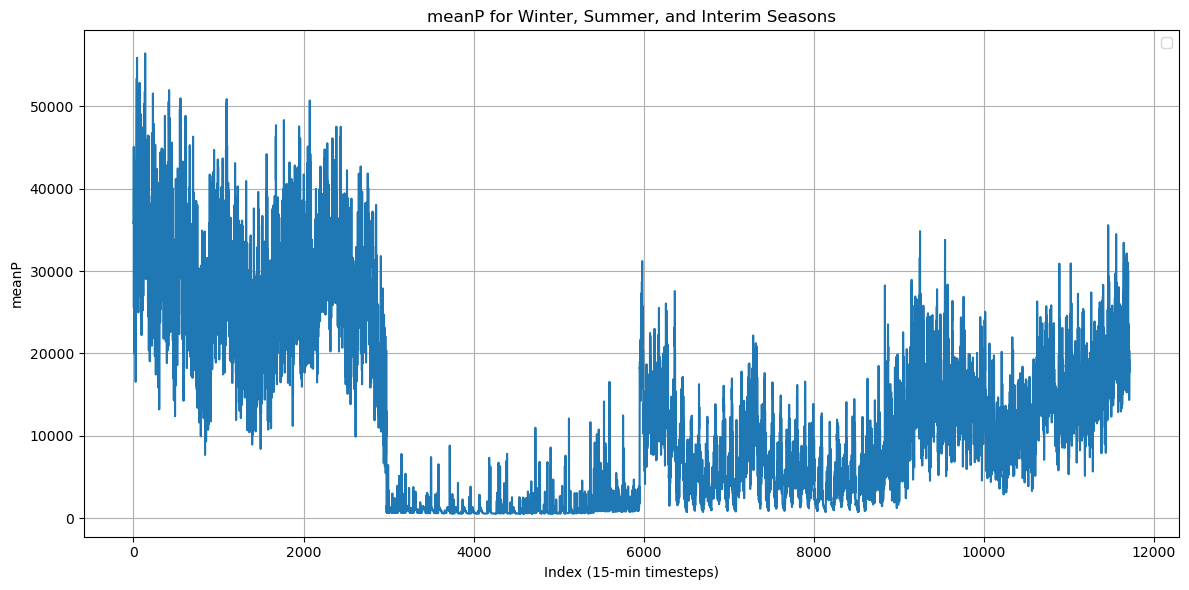

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file with proper settings for separator and decimal point
file_path = "realData.csv"
df = pd.read_csv(file_path, delimiter=';', decimal=',')

# Plot all three seasons in the same figure
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['P_HEATPUMP'])
print(f"Max: {df['P_HEATPUMP'].max()}, Mean: {df['P_HEATPUMP'].mean()}")
# Add labels, title, and legend
plt.xlabel('Index (15-min timesteps)')
plt.ylabel('meanP')
plt.title('meanP for Winter, Summer, and Interim Seasons')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [25]:
import pandas as pd

# Path to your CSV file
file_path = "pvPrognosis.csv"  # Replace with your actual file path

# Load the CSV into a DataFrame
df = pd.read_csv(file_path, sep=";")  # Adjust the separator if needed

# Clean and convert numeric columns safely
for col in ['meanP', 'stdP', 'meanQ', 'stdQ']:
    # Replace commas with dots and remove whitespace
    df[col] = (
        df[col]
        .astype(str)  # Ensure all values are strings
        .str.replace(r'\s+', '', regex=True)  # Remove spaces
        .str.replace(',', '.')  # Replace commas with dots
    )
    # Convert to float
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check for NaN values after conversion
if df[['meanP', 'stdP', 'meanQ', 'stdQ']].isnull().any().any():
    print("Warning: Some values could not be converted to numeric and are NaN.")

# Preserve the custom order of seasons
season_order = ['winter', 'summer', 'interim']
df['season'] = pd.Categorical(df['season'], categories=season_order, ordered=True)

# Group by 'season', 'dayOfWeek', and 'hour' (discard 'minute' for 1-hour resolution)
resampled_df = df.groupby(['season', 'dayOfWeek', 'hour']).mean().reset_index()

# Drop unnecessary columns
resampled_df = resampled_df.drop(columns=['minute', 'Unnamed: 0'], errors='ignore')

# Sort the DataFrame to ensure the order of seasons is maintained
resampled_df = resampled_df.sort_values(by=['season', 'dayOfWeek', 'hour'])

# Export the resampled data to a new CSV file
output_file = "pvPrognosis1h.csv"
resampled_df.to_csv(output_file, sep=";", index=False)
print(f"Resampled data has been saved to '{output_file}'.")

Resampled data has been saved to 'pvPrognosis1h.csv'.


In [47]:
import pandas as pd

# Path to the CSV file
file_path = "householdPrognosis1h.csv"  # Replace with the correct path to your CSV file

# Load the CSV into a DataFrame
df = pd.read_csv(file_path, delimiter=';')

# Clean 'season' column
df['season'] = df['season'].str.strip()

# Filter data by season
df_winter = df[df['season'] == 'winter'].reset_index(drop=True)
df_summer = df[df['season'] == 'summer'].reset_index(drop=True)
df_interim = df[df['season'] == 'interim'].reset_index(drop=True)

# Print the first few lines
print("First few lines of the 1-hour resolution data:")
print(df_winter.head())
# Print the length of the DataFrame
print(f"The number of rows in the DataFrame: {len(df_winter)}")

First few lines of the 1-hour resolution data:
   season  dayOfWeek  hour        meanP         stdP        meanQ        stdQ
0  winter          0     0  5644.923584  2381.963867 -1198.110107  402.570183
1  winter          0     1  4899.787476  2427.186646 -1119.138092  398.914238
2  winter          0     2  4765.732300  2399.690063 -1109.682739  399.863480
3  winter          0     3  4875.983887  2381.512817 -1093.221954  403.824745
4  winter          0     4  5199.724487  2338.309021 -1072.544617  396.836433
The number of rows in the DataFrame: 168


In [ ]:
T_amb = df['APPARENT_TEMPERATURE:TOTAL']

In [ ]:
print(T_amb)